# Diabetes Classifier - SVM

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

### Testing on Balanced dataset

In [22]:
diabetes_balanced = pd.read_csv(r"C:\Users\karni\OneDrive\Documents\GitHub\diabetes-classifier\data\diabetes_binary_5050split_health_indicators_BRFSS2015.csv")
diabetes_balanced.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [23]:
diabetes_balanced.shape
diabetes_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

In [24]:
columns_to_drop = [
    'CholCheck',
    'Stroke',
    'HvyAlcoholConsump',
    'AnyHealthcare',
    'NoDocbcCost',
    'Education',
]

diabetes_balanced = diabetes_balanced.drop(columns = columns_to_drop)

In [25]:

diabetes_balanced.head()

,Diabetes_binary,HighBP,HighChol,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Income
0,0.0,1.0,0.0,26.0,0.0,0.0,1.0,0.0,1.0,3.0,5.0,30.0,0.0,1.0,4.0,8.0
1,0.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,8.0
2,0.0,0.0,0.0,26.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,10.0,0.0,1.0,13.0,8.0
3,0.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,3.0,0.0,3.0,0.0,1.0,11.0,8.0
4,0.0,0.0,0.0,29.0,1.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,8.0,8.0


In [26]:
X = diabetes_balanced.drop('Diabetes_binary', axis=1)
y = diabetes_balanced[['Diabetes_binary']]

In [27]:
class SVM_RFF:
    def __init__(self, X, y, learning_rate=0.001, lambda_param=0.01, n_iters=2500, tolerance=1e-4, gamma=0.1, D=500):
        self.X = X
        self.y = y
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.tolerance = tolerance
        self.gamma = gamma
        self.D = D

    def train_test_split(self):
        strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=17)
        for train_idx, test_idx in strat_split.split(self.X, self.y):
            self.X_train = self.X.iloc[train_idx]
            self.X_test = self.X.iloc[test_idx]
            self.y_train = self.y.iloc[train_idx].values.ravel()
            self.y_test = self.y.iloc[test_idx].values.ravel()

    def robust_scale(self, column, median=None, iqr=None):
        if median is None:
            median = np.median(column)
        if iqr is None:
            q1 = np.percentile(column, 25)
            q3 = np.percentile(column, 75)
            iqr = q3 - q1
        return (column - median) / iqr, median, iqr

    def scale_xTrain(self):
        self.X_train['GenHlth'] = 6 - self.X_train['GenHlth']
        numerical_cols = ['BMI', 'MentHlth', 'PhysHlth']
        self.train_scaling_params = {}

        for col in numerical_cols:
            self.X_train[col], median, iqr = self.robust_scale(self.X_train[col])
            self.train_scaling_params[col] = (median, iqr)

        self.X_train = self.X_train.values

    def scale_xTest(self):
        self.X_test['GenHlth'] = 6 - self.X_test['GenHlth']
        numerical_cols = ['BMI', 'MentHlth', 'PhysHlth']

        for col in numerical_cols:
            median, iqr = self.train_scaling_params[col]
            self.X_test[col], _, _ = self.robust_scale(self.X_test[col], median, iqr)

        self.X_test = self.X_test.values

    def apply_random_fourier_features(self, X):
        projection = X.dot(self.W.T) + self.b
        return np.sqrt(2 / self.D) * np.cos(projection)

    def init_rff(self):
        d = self.X_train.shape[1]
        self.W = np.random.normal(scale=np.sqrt(2 * self.gamma), size=(self.D, d))
        self.b = np.random.uniform(0, 2 * np.pi, size=self.D)

        self.Z_train = self.apply_random_fourier_features(self.X_train)
        self.Z_test = self.apply_random_fourier_features(self.X_test)

    def fit_model(self):
        n_samples, n_features = self.Z_train.shape
        y_ = np.where(self.y_train <= 0, -1, 1)
        self.w = np.zeros(n_features)
        self.b_svm = 0

        for i in tqdm(range(self.n_iters), desc="Training"):
            w_prev = self.w.copy()
            for idx, z_i in enumerate(self.Z_train):
                condition = y_[idx] * (np.dot(z_i, self.w) + self.b_svm) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - y_[idx] * z_i)
                    self.b_svm += self.lr * y_[idx]

            if np.linalg.norm(self.w - w_prev) < self.tolerance:
                print(f"Converged at iteration {i}")
                break

    def decision_function(self, Z):
        return np.dot(Z, self.w) + self.b_svm

    def predict(self, Z):
        return (self.decision_function(Z) >= 0).astype(int)

    def predict_proba(self, Z):
        return self.decision_function(Z)

    def report_metrics(self):
        y_pred = self.predict(self.Z_test)
        accuracy = np.mean(y_pred == self.y_test)
        precision = precision_score(self.y_test, y_pred)
        recall = recall_score(self.y_test, y_pred)
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        self.plot_confusion_matrix(self.y_test, y_pred)

    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['No Diabetes', 'Diabetes'],
                    yticklabels=['No Diabetes', 'Diabetes'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

    def plot_roc_curve(self):
        y_scores = self.predict_proba(self.Z_test)
        fpr, tpr, _ = roc_curve(self.y_test, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend()
        plt.grid(True)
        plt.show()

    def fit(self):
        self.train_test_split()
        self.scale_xTrain()
        self.scale_xTest()
        self.init_rff()
        self.fit_model()
        self.report_metrics()

Training: 100%|██████████| 1000/1000 [05:45<00:00,  2.90it/s]

Accuracy: 0.6908
Precision: 0.6497
Recall: 0.8280


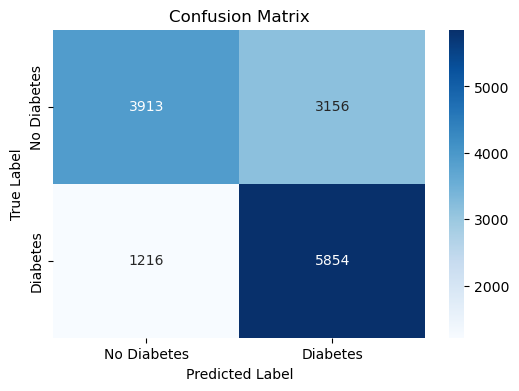

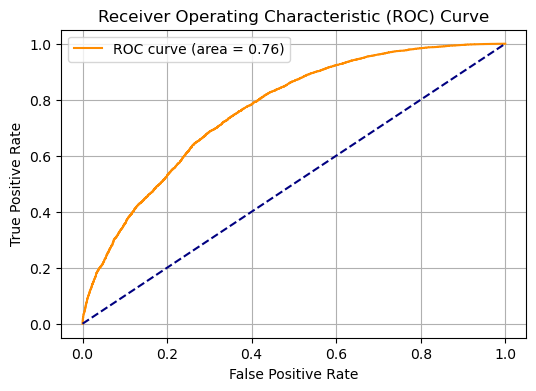

In [29]:
svm_rff = SVM_RFF(X, y, gamma=0.05, D=500, n_iters=1000)
svm_rff.fit()
svm_rff.plot_roc_curve()

In [ ]:
from itertools import product
from sklearn.metrics import roc_auc_score

def tune_hyperparameters(X, y, gamma_list, D_list, lambda_list):
    best_score = -1
    best_config = None
    results = []

    for gamma, D, lam in product(gamma_list, D_list, lambda_list):
        print(f"\n Trying gamma={gamma}, D={D}, lambda={lam}")
        model = SVM_RFF(X, y,
                        gamma=gamma,
                        D=D,
                        lambda_param=lam,
                        learning_rate=0.001,
                        n_iters=1000,
                        tolerance=1e-4)

        model.fit()
        y_pred = model.predict(model.Z_test)
        y_scores = model.predict_proba(model.Z_test)
        
        accuracy = np.mean(y_pred == model.y_test)
        precision = precision_score(model.y_test, y_pred)
        recall = recall_score(model.y_test, y_pred)
        roc_auc = roc_auc_score(model.y_test, y_scores)

        print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {roc_auc:.4f}")

        results.append({
            'gamma': gamma,
            'D': D,
            'lambda': lam,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'auc': roc_auc
        })

        if roc_auc > best_score:
            best_score = roc_auc
            best_config = (gamma, D, lam)

    print("\n Best Config:")
    print(f"gamma={best_config[0]}, D={best_config[1]}, lambda={best_config[2]}, AUC={best_score:.4f}")
    
    return best_config, results



🔍 Trying gamma=0.01, D=300, lambda=0.001


Training: 100%|██████████| 1000/1000 [04:51<00:00,  3.43it/s]


Accuracy: 0.7337
Precision: 0.6981
Recall: 0.8238


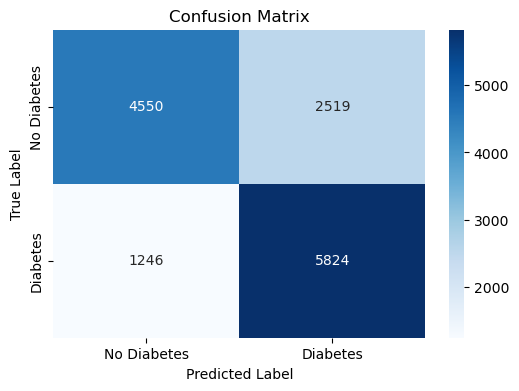

 Accuracy: 0.7337, Precision: 0.6981, Recall: 0.8238, AUC: 0.8089

🔍 Trying gamma=0.01, D=300, lambda=0.01


Training: 100%|██████████| 1000/1000 [05:15<00:00,  3.17it/s]

Accuracy: 0.6938
Precision: 0.6642
Recall: 0.7840


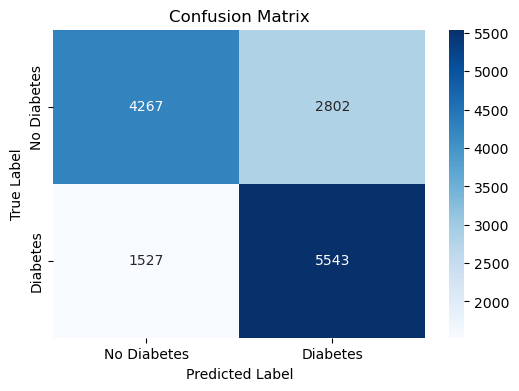

 Accuracy: 0.6938, Precision: 0.6642, Recall: 0.7840, AUC: 0.7614

🔍 Trying gamma=0.01, D=500, lambda=0.001


Training: 100%|██████████| 1000/1000 [08:21<00:00,  1.99it/s]

Accuracy: 0.7355
Precision: 0.7030
Recall: 0.8156


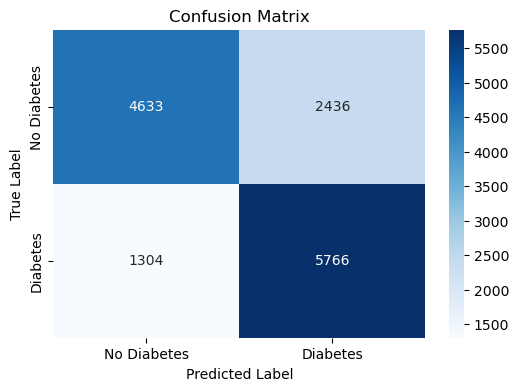

 Accuracy: 0.7355, Precision: 0.7030, Recall: 0.8156, AUC: 0.8103

🔍 Trying gamma=0.01, D=500, lambda=0.01


Training: 100%|██████████| 1000/1000 [06:59<00:00,  2.38it/s]

Accuracy: 0.6911
Precision: 0.6563
Recall: 0.8025


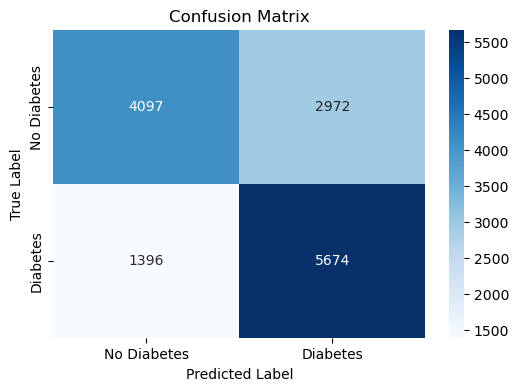

 Accuracy: 0.6911, Precision: 0.6563, Recall: 0.8025, AUC: 0.7562

🔍 Trying gamma=0.05, D=300, lambda=0.001


Training: 100%|██████████| 1000/1000 [04:26<00:00,  3.76it/s]

Accuracy: 0.7272
Precision: 0.6979
Recall: 0.8014


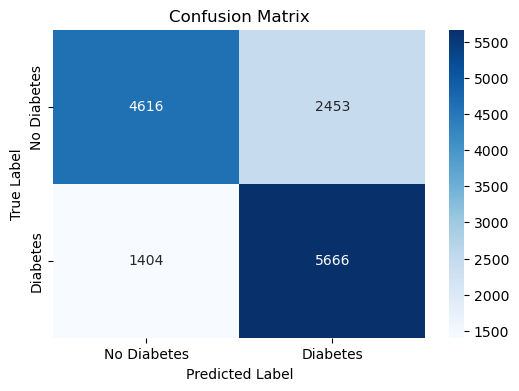

 Accuracy: 0.7272, Precision: 0.6979, Recall: 0.8014, AUC: 0.8017

🔍 Trying gamma=0.05, D=300, lambda=0.01


Training: 100%|██████████| 1000/1000 [04:53<00:00,  3.41it/s]

Accuracy: 0.6946
Precision: 0.6572
Recall: 0.8136


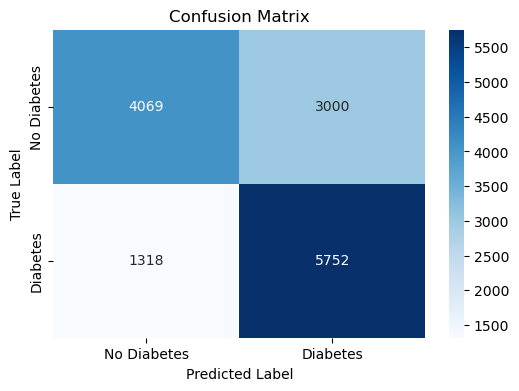

 Accuracy: 0.6946, Precision: 0.6572, Recall: 0.8136, AUC: 0.7680

🔍 Trying gamma=0.05, D=500, lambda=0.001


Training: 100%|██████████| 1000/1000 [04:39<00:00,  3.57it/s]

Accuracy: 0.7302
Precision: 0.6939
Recall: 0.8238


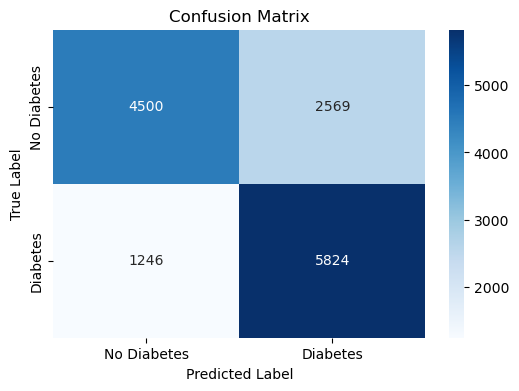

 Accuracy: 0.7302, Precision: 0.6939, Recall: 0.8238, AUC: 0.8064

🔍 Trying gamma=0.05, D=500, lambda=0.01


Training: 100%|██████████| 1000/1000 [09:43<00:00,  1.71it/s]

Accuracy: 0.6913
Precision: 0.6475
Recall: 0.8397


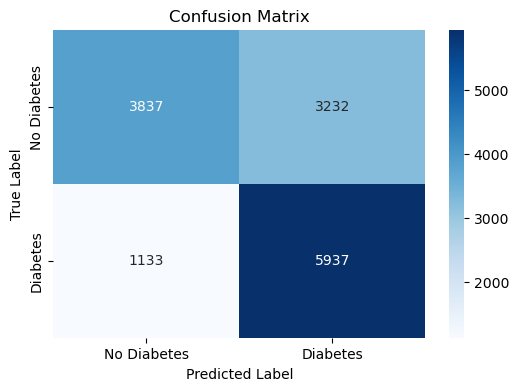

 Accuracy: 0.6913, Precision: 0.6475, Recall: 0.8397, AUC: 0.7730

🔍 Trying gamma=0.1, D=300, lambda=0.001


Training: 100%|██████████| 1000/1000 [07:21<00:00,  2.27it/s]

Accuracy: 0.7158
Precision: 0.6785
Recall: 0.8205


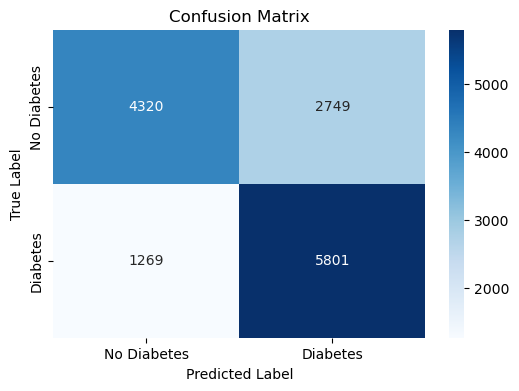

 Accuracy: 0.7158, Precision: 0.6785, Recall: 0.8205, AUC: 0.7863

🔍 Trying gamma=0.1, D=300, lambda=0.01


Training: 100%|██████████| 1000/1000 [19:57<00:00,  1.20s/it]

Accuracy: 0.6807
Precision: 0.6323
Recall: 0.8636


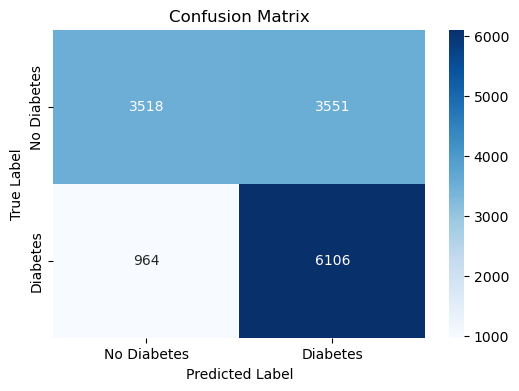

 Accuracy: 0.6807, Precision: 0.6323, Recall: 0.8636, AUC: 0.7497

🔍 Trying gamma=0.1, D=500, lambda=0.001


Training: 100%|██████████| 1000/1000 [21:35<00:00,  1.30s/it]


Accuracy: 0.7197
Precision: 0.6813
Recall: 0.8256


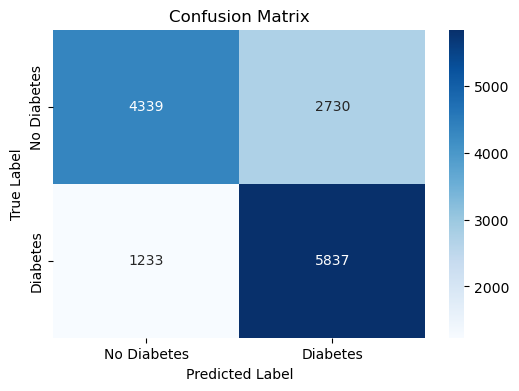

 Accuracy: 0.7197, Precision: 0.6813, Recall: 0.8256, AUC: 0.7920

🔍 Trying gamma=0.1, D=500, lambda=0.01


Training: 100%|██████████| 1000/1000 [19:39<00:00,  1.18s/it]

Accuracy: 0.6744
Precision: 0.6278
Recall: 0.8573


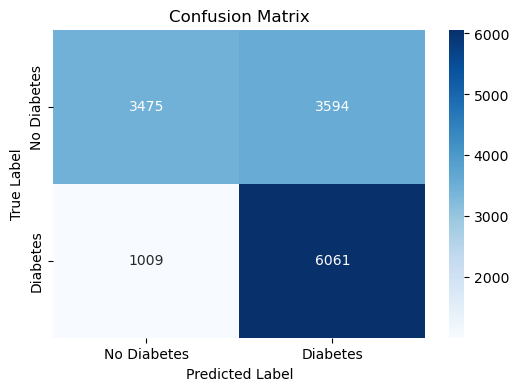

 Accuracy: 0.6744, Precision: 0.6278, Recall: 0.8573, AUC: 0.7519

 Best Config:
gamma=0.01, D=500, lambda=0.001, AUC=0.8103


In [31]:
gamma_values = [0.01, 0.05, 0.1]
D_values = [300, 500]
lambda_values = [0.001, 0.01]

best_config, all_results = tune_hyperparameters(X, y, gamma_values, D_values, lambda_values)